In [1]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Lifetime Value prediction for Kaggle Acquire Valued Customer Challenge

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [2]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import tqdm
from typing import Sequence

# install and import ltv
#!pip install -q git+https://github.com/google/lifetime_value
import lifetime_value as ltv

2024-12-01 16:24:57.003375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 16:24:57.017586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733070297.034564   30562 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733070297.039846   30562 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 16:24:57.057502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
tfd = tfp.distributions
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None  # default='warn'

## Global variables

In [4]:
COMPANY = '103600030'  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
#MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
MODEL = 'linear'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param { isTemplate: true, type: 'integer'}
DATA_FOLDER = './tmp/acquire-valued-shoppers-challenge' # @param { isTemplate: true, type: 'string'}
OUTPUT_CSV_FOLDER = f'{DATA_FOLDER}/result'  # @param { isTemplate: true, type: 'string'}

In [5]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Data

### Download data

Setup kaggle API correctly following https://www.kaggle.com/docs/api
```
%%shell
mkdir ~/.kaggle
echo \{\"username\":\"{your kaggle username}\",\"key\":\"{your kaggle api key}\"\} > ~/.kaggle/kaggle.json
pip install kaggle
```

In [6]:
# Set it DATA_FOLDER as an environment variable
%env DATA_FOLDER=$DATA_FOLDER

env: DATA_FOLDER=./tmp/acquire-valued-shoppers-challenge


In [7]:
%%bash
if [ -e $DATA_FOLDER/transactions.csv ]
then
  echo "File already exists, no need to download."
else
  rm -rf $DATA_FOLDER
  mkdir -p $DATA_FOLDER
  cd $DATA_FOLDER
  kaggle competitions download -c acquire-valued-shoppers-challenge
  echo "Unzip file. This may take 10 min."
  unzip acquire-valued-shoppers-challenge.zip transactions.csv.gz
  gunzip transactions.csv.gz
fi

File already exists, no need to download.


### Load transaction csv

In [8]:
def load_transaction_data(company):
  all_data_filename = f'{DATA_FOLDER}/transactions.csv'
  one_company_data_filename = f'{DATA_FOLDER}/transactions_company_{company}.csv'
  if os.path.isfile(one_company_data_filename):
    df = pd.read_csv(one_company_data_filename)
  else:
    data_list = []
    chunksize = 10**6
    # 350 iterations
    for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
      data_list.append(chunk.query("company=={}".format(company)))
    df = pd.concat(data_list, axis=0)
    df.to_csv(one_company_data_filename, index=None)
  return df

### Preprocess data

In [9]:
def preprocess(df):
  df = df.query('purchaseamount>0')
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df['start_date'] = df.groupby('id')['date'].transform('min')

  # Compute calibration values
  calibration_value = (
      df.query('date==start_date').groupby('id')
      ['purchaseamount'].sum().reset_index())
  calibration_value.columns = ['id', 'calibration_value']

  # Compute holdout values
  one_year_holdout_window_mask = (
      (df['date'] > df['start_date']) &
      (df['date'] <= df['start_date'] + np.timedelta64(365, 'D')))
  holdout_value = (
      df[one_year_holdout_window_mask].groupby('id')
      ['purchaseamount'].sum().reset_index())
  holdout_value.columns = ['id', 'holdout_value']

  # Compute calibration attributes
  calibration_attributes = (
      df.query('date==start_date').sort_values(
          'purchaseamount', ascending=False).groupby('id')[[
              'chain', 'dept', 'category', 'brand', 'productmeasure'
          ]].first().reset_index())

  # Merge dataframes
  customer_level_data = (
      calibration_value.merge(calibration_attributes, how='left',
                              on='id').merge(
                                  holdout_value, how='left', on='id'))
  customer_level_data['holdout_value'] = (
      customer_level_data['holdout_value'].fillna(0.))
  customer_level_data[CATEGORICAL_FEATURES] = (
      customer_level_data[CATEGORICAL_FEATURES].fillna('UNKNOWN'))

  # Specify data types
  customer_level_data['log_calibration_value'] = (
      np.log(customer_level_data['calibration_value']).astype('float32'))
  customer_level_data['chain'] = (
      customer_level_data['chain'].astype('category'))
  customer_level_data['dept'] = (customer_level_data['dept'].astype('category'))
  customer_level_data['brand'] = (
      customer_level_data['brand'].astype('category'))
  customer_level_data['category'] = (
      customer_level_data['category'].astype('category'))
  customer_level_data['label'] = (
      customer_level_data['holdout_value'].astype('float32'))
  return customer_level_data

### Load customer-level csv

In [10]:
def load_customer_level_csv(company):
  customer_level_data_file = f'{DATA_FOLDER}/customer_level_data_company_{company}.csv'
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    customer_level_data = preprocess(load_transaction_data(company))
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [11]:
# Processes data. 350 iteration in total. May take 10min.
customer_level_data = load_customer_level_csv(COMPANY)

In [12]:
customer_level_data

,id,calibration_value,chain,dept,category,brand,productmeasure,holdout_value,log_calibration_value,label
0,86246,4.98,205,26,2630,9787,CT,173.000000,1.605430,173.00
1,86252,6.84,205,26,2614,9878,CT,167.100006,1.922788,167.10
2,12262064,3.99,95,26,2614,9878,CT,2.490000,1.383791,2.49
3,12277270,1.99,95,26,2630,9787,CT,3.990000,0.688135,3.99
4,12332190,7.99,95,26,2634,4139,RL,96.360001,2.078191,96.36
...,...,...,...,...,...,...,...,...,...,...
225177,4821651378,6.99,46,26,2634,4139,RL,0.000000,1.944481,0.00
225178,4821703398,4.98,46,26,2634,4139,RL,0.000000,1.605430,0.00
225179,4836226081,24.99,46,26,2613,8583,CT,0.000000,3.218476,0.00
225180,4847628950,5.99,166,26,2632,8583,CT,3.490000,1.790091,3.49


We observe a mixture of zero and lognormal distribution of holdout value.

<Axes: >

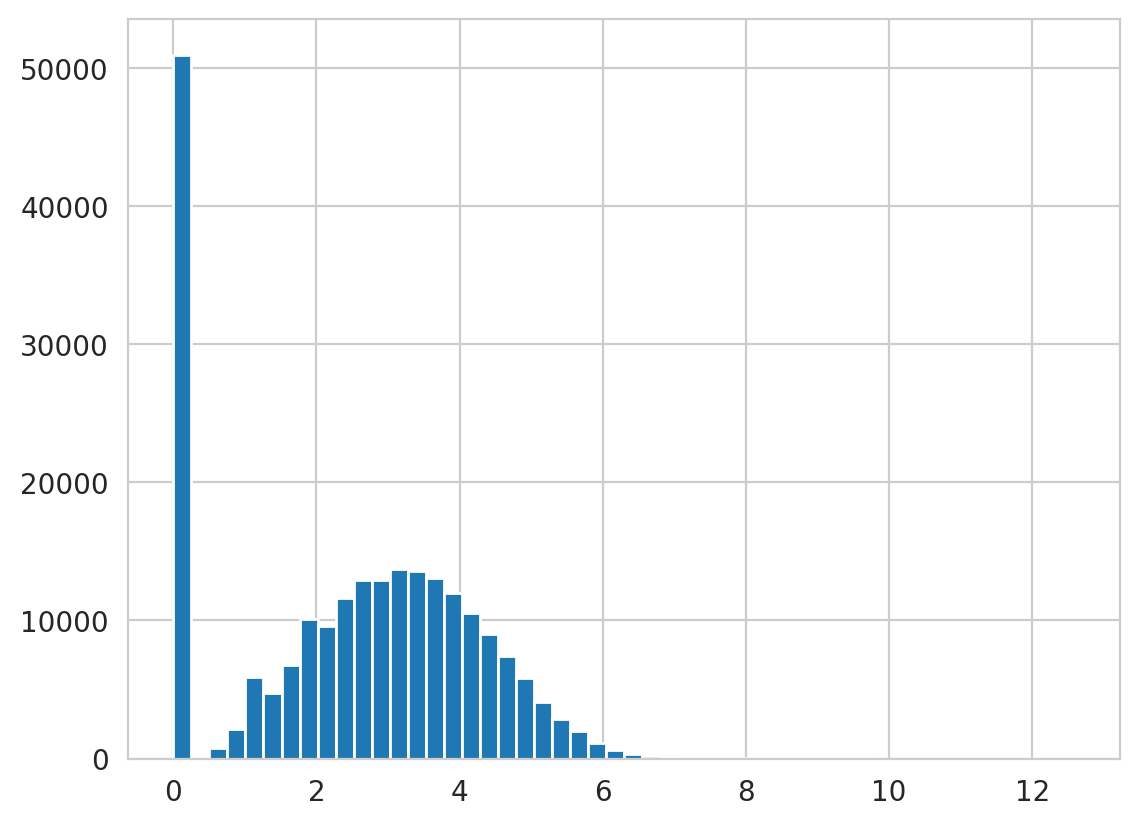

In [13]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

### Make train/eval

In [14]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values
  y0 = df['calibration_value'].values

  x_train, x_eval, y_train, y_eval, y0_train, y0_eval = (
      model_selection.train_test_split(
          x, y, y0, test_size=0.2, random_state=123))

  return x_train, x_eval, y_train, y_eval, y0_eval

In [15]:
def dnn_split(df):
  for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df[key] = encoder.fit_transform(df[key])

  y0 = df['calibration_value'].values
  df_train, df_eval, y0_train, y0_eval = model_selection.train_test_split(
      df, y0, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].values
    return features

  x_train, y_train = feature_dict(df_train), df_train['label'].values
  x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values

  return x_train, x_eval, y_train, y_eval, y0_eval

## Model

In [16]:
def linear_model(output_units, input_dim):
  return tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(output_units, activation=None)
  ])

In [17]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size)
      ),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units, df):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].nunique())(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

### Train

In [18]:
if LOSS == 'mse':
  loss = keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [19]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval, y0_eval = linear_split(customer_level_data)
  model = linear_model(output_units, x_train.shape[1])

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval, y0_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

I0000 00:00:1733070300.074819   30562 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21971 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [20]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [21]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [22]:
# y array needs to have a two dimensional shape to work with ziln loss function
# so we use [:, np.newaxis] to make the data two-dimensional for the fit function call
history = model.fit(
    x=x_train,
    y=y_train[:, np.newaxis],
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval[:, np.newaxis])).history

Epoch 1/400


I0000 00:00:1733070301.742468   30719 service.cc:148] XLA service 0x7d6bf4004a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733070301.742508   30719 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-12-01 16:25:01.767512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733070301.851362   30719 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-01 16:25:01.913238: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1733070302.10

176/176 - 2s - 11ms/step - loss: 14.8400 - val_loss: 12.4797 - learning_rate: 2.0000e-04
Epoch 2/400
176/176 - 0s - 1ms/step - loss: 10.9974 - val_loss: 9.7725 - learning_rate: 2.0000e-04
Epoch 3/400
176/176 - 0s - 2ms/step - loss: 8.9266 - val_loss: 8.2053 - learning_rate: 2.0000e-04
Epoch 4/400
176/176 - 0s - 2ms/step - loss: 7.6717 - val_loss: 7.2098 - learning_rate: 2.0000e-04
Epoch 5/400
176/176 - 0s - 2ms/step - loss: 6.8479 - val_loss: 6.5333 - learning_rate: 2.0000e-04
Epoch 6/400
176/176 - 0s - 2ms/step - loss: 6.2756 - val_loss: 6.0521 - learning_rate: 2.0000e-04
Epoch 7/400
176/176 - 0s - 2ms/step - loss: 5.8610 - val_loss: 5.6963 - learning_rate: 2.0000e-04
Epoch 8/400
176/176 - 0s - 2ms/step - loss: 5.5504 - val_loss: 5.4262 - learning_rate: 2.0000e-04
Epoch 9/400
176/176 - 0s - 1ms/step - loss: 5.3114 - val_loss: 5.2155 - learning_rate: 2.0000e-04
Epoch 10/400
176/176 - 0s - 2ms/step - loss: 5.1234 - val_loss: 5.0483 - learning_rate: 2.0000e-04
Epoch 11/400
176/176 - 0s -

<Axes: >

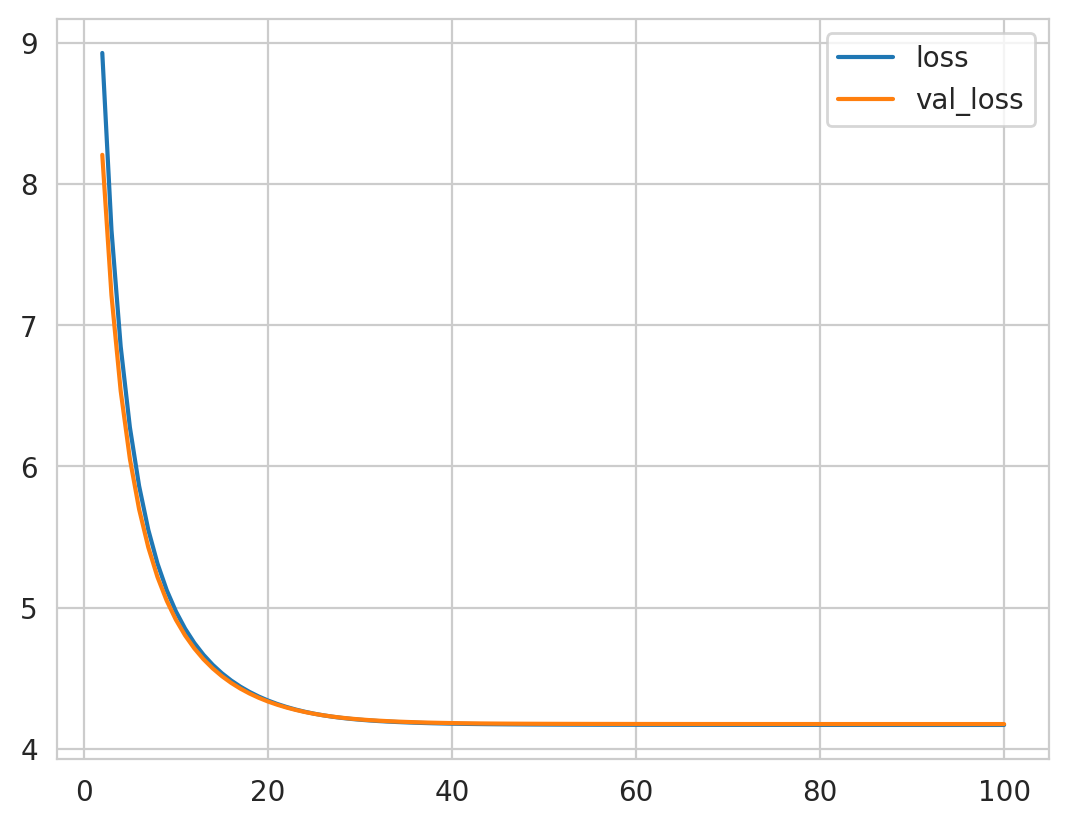

In [23]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

### Eval

In [24]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [25]:
df_pred = pd.DataFrame({
    'y_true': y_eval,
    'y_pred': y_pred,
})
df_pred.head(10)

,y_true,y_pred
0,1.57,17.481907
1,23.16,22.109489
2,252.28,172.726791
3,5.49,40.280609
4,3.69,49.700878
5,2.48,15.275944
6,45.31,42.780106
7,30.95,17.575140
8,11.94,19.751925
9,40.55,55.021183


### Gini Coefficient

In [26]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, y0_eval),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [27]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

Text(0.5, 1.0, 'Gain Chart')

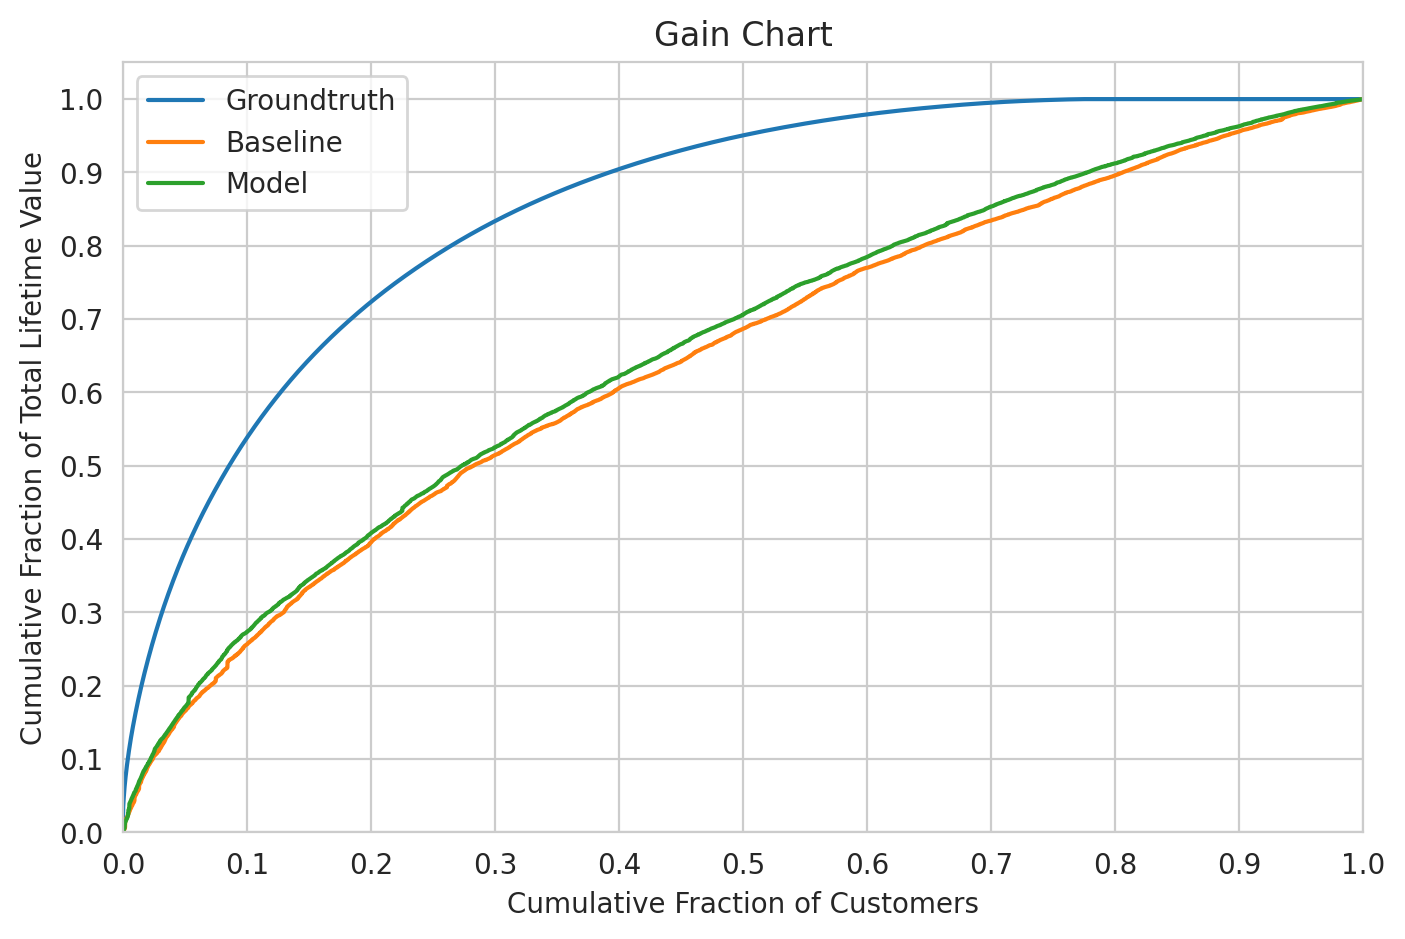

In [28]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='upper left')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart')

In [29]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/lifetime_value/metrics.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized = raw / raw[0]


,raw,normalized
lorenz,0.706898,1.000000
baseline,0.290027,0.410281
model,0.318668,0.450797


### Calibration

In [30]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/lifetime_value/metrics.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('decile').apply(_aggregate_fn)


,label_mean,pred_mean,normalized_rmse,normalized_mae,decile_mape
decile,,,,,
0,14.517410,12.735739,2.375421,1.078516,0.122726
1,19.903028,19.084566,2.192342,1.075551,0.041123
2,23.123633,23.217894,1.786746,1.007889,0.004076
3,27.132077,27.383957,2.114928,1.011596,0.009283
4,30.900364,31.740614,1.816184,1.021783,0.027192
5,33.263915,36.571705,1.636965,1.028215,0.099441
6,37.890115,41.504471,1.620571,0.985880,0.095390
7,46.056345,48.930202,2.767205,0.976870,0.062399
8,52.892995,62.775135,1.462108,1.025097,0.186833


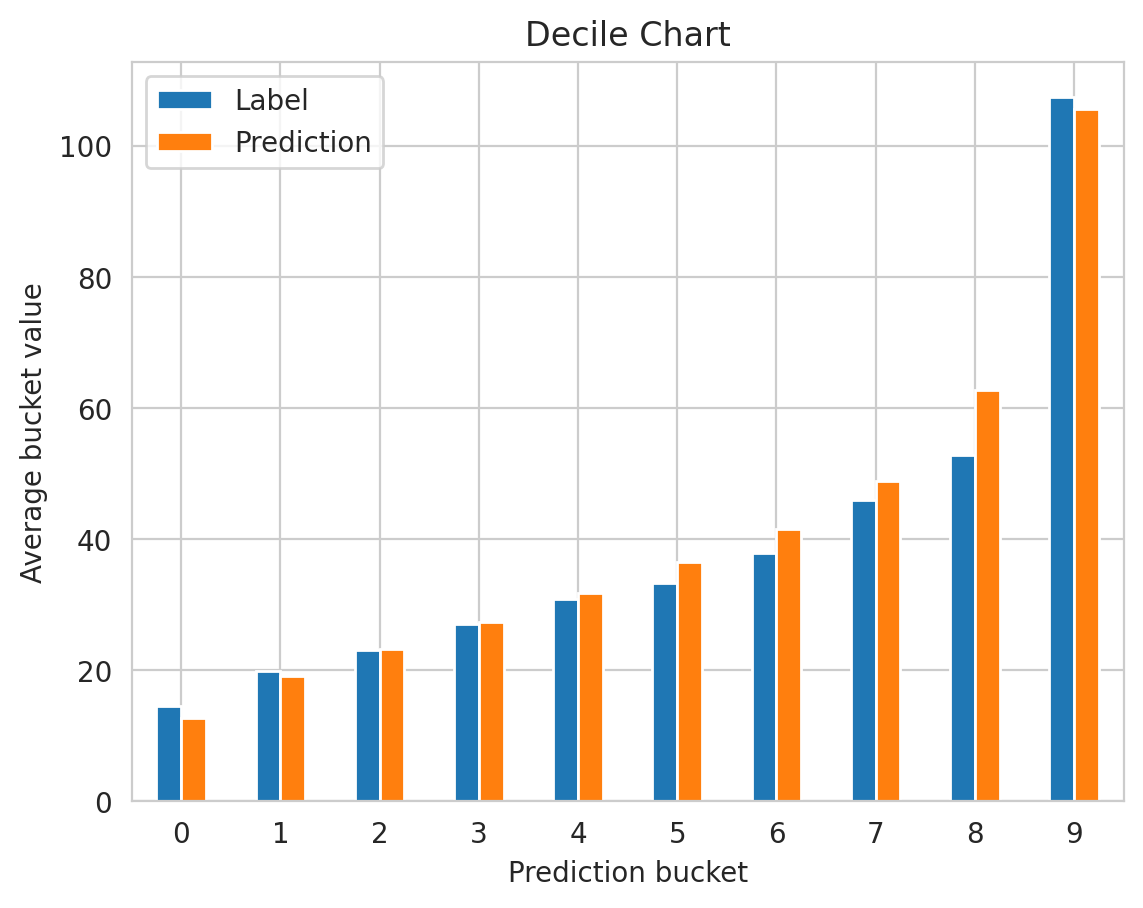

In [31]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left')

### Rank Correlation

In [32]:
def spearmanr(x1: Sequence[float], x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

np.float64(0.3040081261601439)

### All metrics together

In [33]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_eval.mean(),
        'pred_mean': y_pred.mean(),
        'label_positive': np.mean(y_eval > 0),
        'decile_mape': df_decile['decile_mape'].mean(),
        'baseline_gini': gini['normalized'][1],
        'gini': gini['normalized'][2],
        'spearman_corr': spearman_corr,
    },
    index=[0])

/tmp/ipykernel_30562/360493497.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'baseline_gini': gini['normalized'][1],
/tmp/ipykernel_30562/360493497.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'gini': gini['normalized'][2],


In [34]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'label_positive',
    'decile_mape',
    'baseline_gini',
    'gini',
    'spearman_corr',
]]

,company,model,loss,label_mean,pred_mean,label_positive,decile_mape,baseline_gini,gini,spearman_corr
0,103600030,linear,ziln,39.295242,40.945999,0.774563,0.066463,0.410281,0.450797,0.304008


## Save

In [35]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, COMPANY)

In [36]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [37]:
output_file = os.path.join(output_path,
                           '{}_regression_{}.csv'.format(MODEL, LOSS))

In [38]:
df_metrics.to_csv(output_file, index=False)